# RNN without categories

In this notebook I create a RNN as in the `RNN.ipynb` but we do not do the OHE of the categories. Instead we feed the variables that go into the category calculation directly into the RNN.

In [1]:
import h5py
!pip install tables

import numpy as np
import sys
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

from keras.layers import GRU, LSTM, Dense, Dropout, Activation, Masking, Embedding, merge, Input, Flatten, concatenate
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.constraints import unitnorm

import seaborn as sns
from IPython.display import clear_output

# %load_ext autoreload
# %autoreload 2

You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


In [2]:
sns.set()
sns.set(rc={'figure.figsize':(15,12)})
sns.set_context('talk', font_scale=1.2)
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [29]:
max_tracks = 20

In [195]:
higgs = pd.read_hdf('data/higgs/higgs.h5', stop=20000)
top = pd.read_hdf('data/top/top.h5', stop=20000)
qcd = pd.read_hdf('data/qcd/qcd.h5', stop=20000)

In [196]:
print(higgs.info())
print(top.info())
print(qcd.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Columns: 561 entries, chiSquared_trk0 to truth_category
dtypes: float64(561)
memory usage: 85.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Columns: 561 entries, chiSquared_trk0 to truth_category
dtypes: float64(561)
memory usage: 85.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Columns: 561 entries, chiSquared_trk0 to truth_category
dtypes: float64(561)
memory usage: 85.8 MB
None


### Some plots

In [202]:
def hist_compare(variable, xlim=None):
    '''Plot the distribution of max_tracks leading tracks of specified variable'''
    
    colors = ['r', 'g', 'b']
    labels = ['higgs', 'top', 'qcd']

    indices = [variable + '_trk' + str(j) for j in range(max_tracks)]
    ax, fig = plt.subplots()
    for i, input_data in enumerate([higgs, top, qcd]):
        data = input_data.loc[:, indices].values.reshape(-1, 1)
        plt.hist(data[~np.isnan(data)], density=True, bins=100, histtype='stepfilled', color=colors[i], alpha=0.3, label=labels[i], linewidth=4)
    ax.legend()
    if xlim:
        plt.xlim(*xlim)
    plt.title('Comparison of {}'.format(variable))
    plt.xlabel(variable)
    plt.ylabel('aribtrary units (histograms are normed)')
    plt.show()

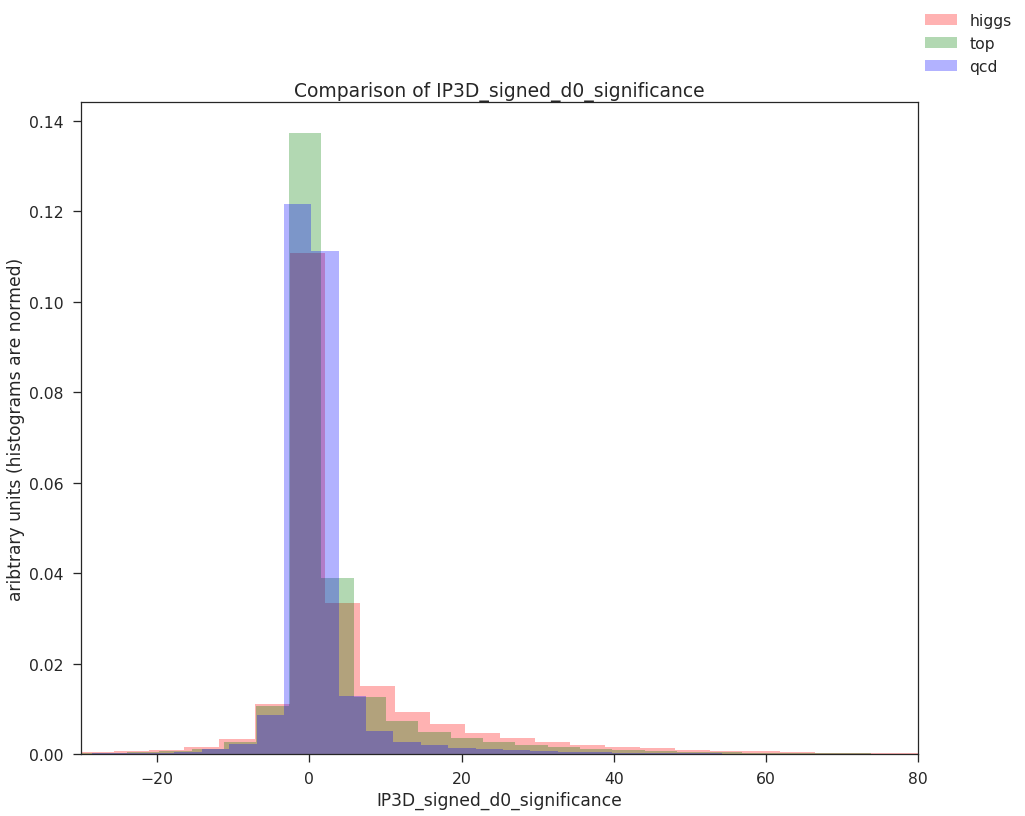

In [203]:
hist_compare('IP3D_signed_d0_significance', xlim=(-30, 80))

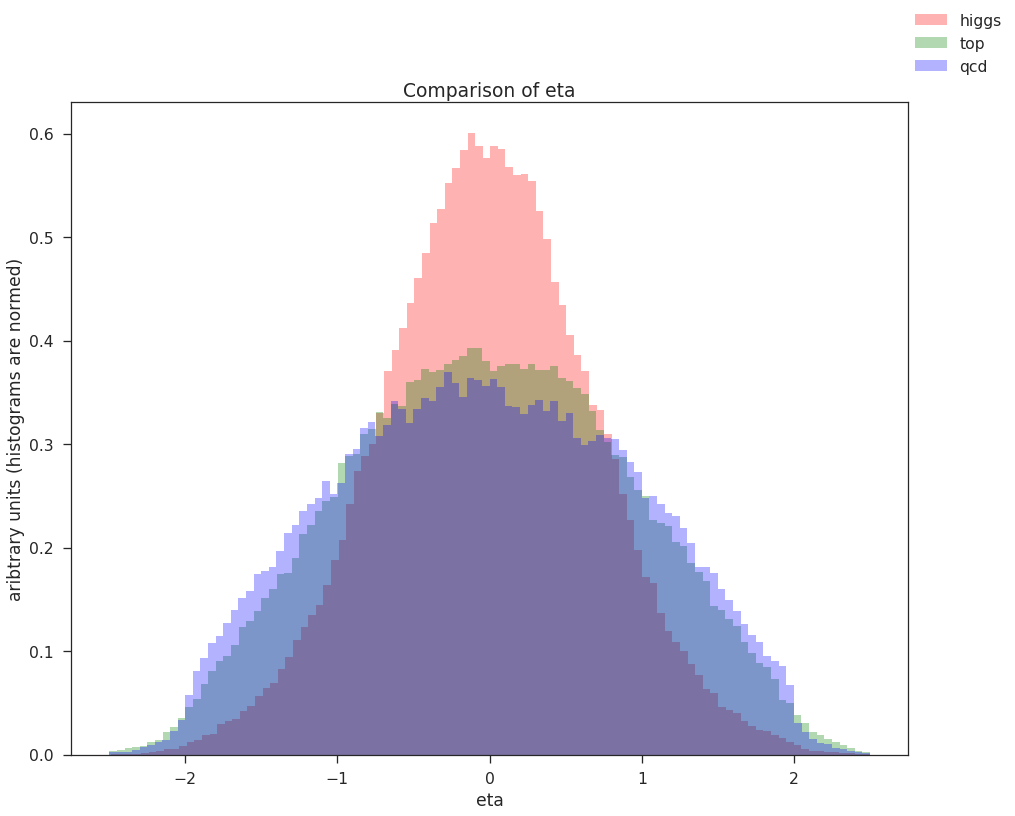

In [204]:
hist_compare('eta')

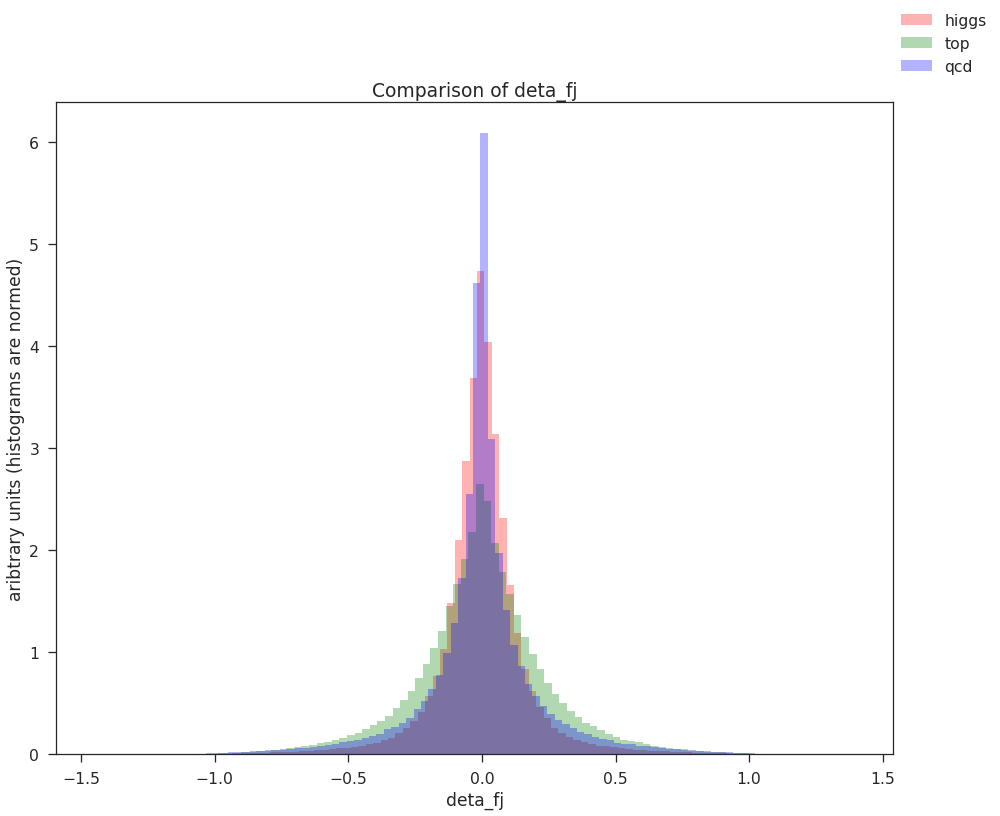

In [206]:
hist_compare('deta_fj')

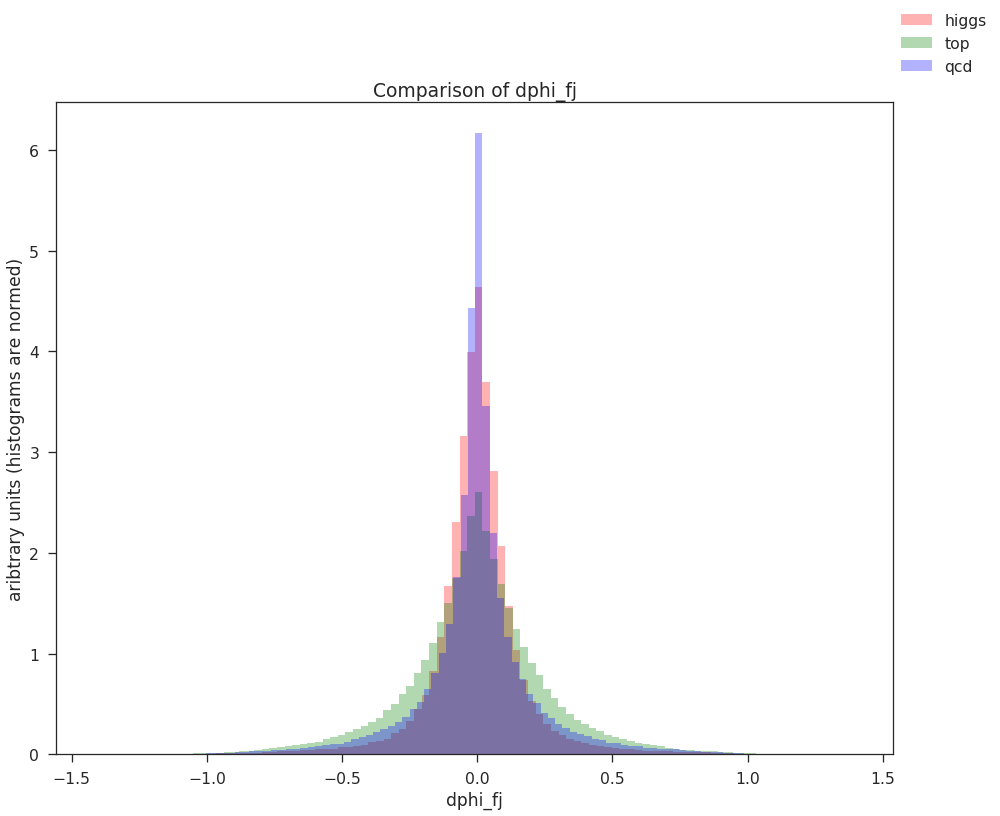

In [207]:
hist_compare('dphi_fj')

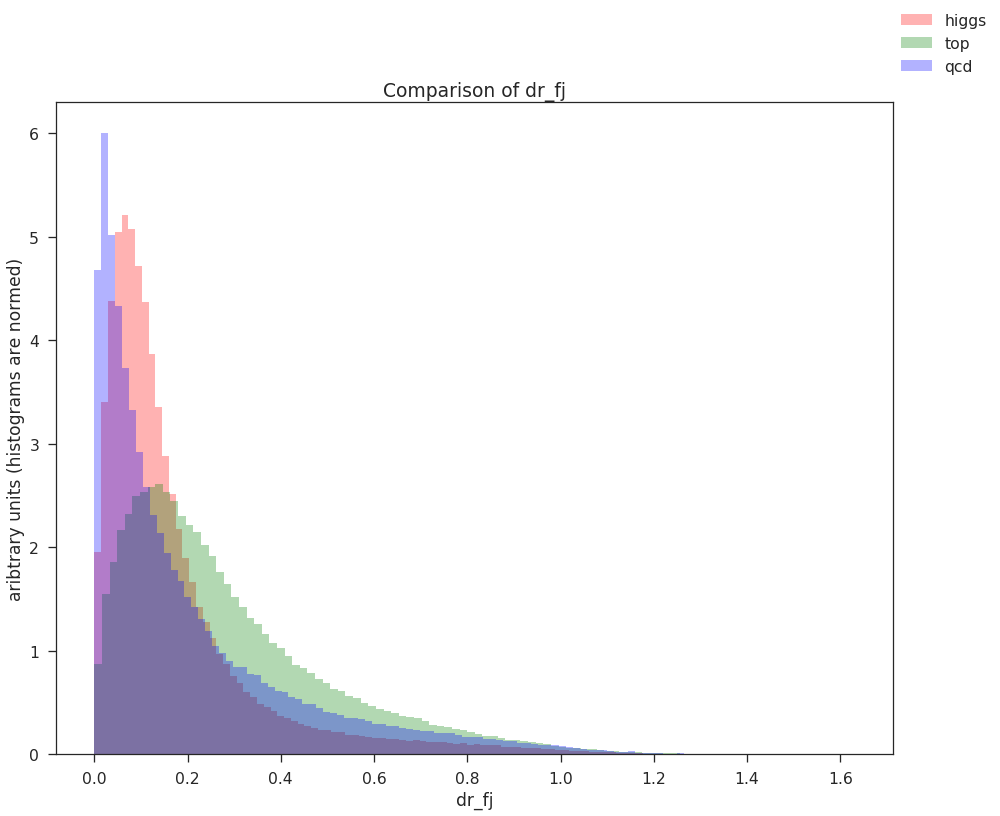

In [208]:
hist_compare('dr_fj')

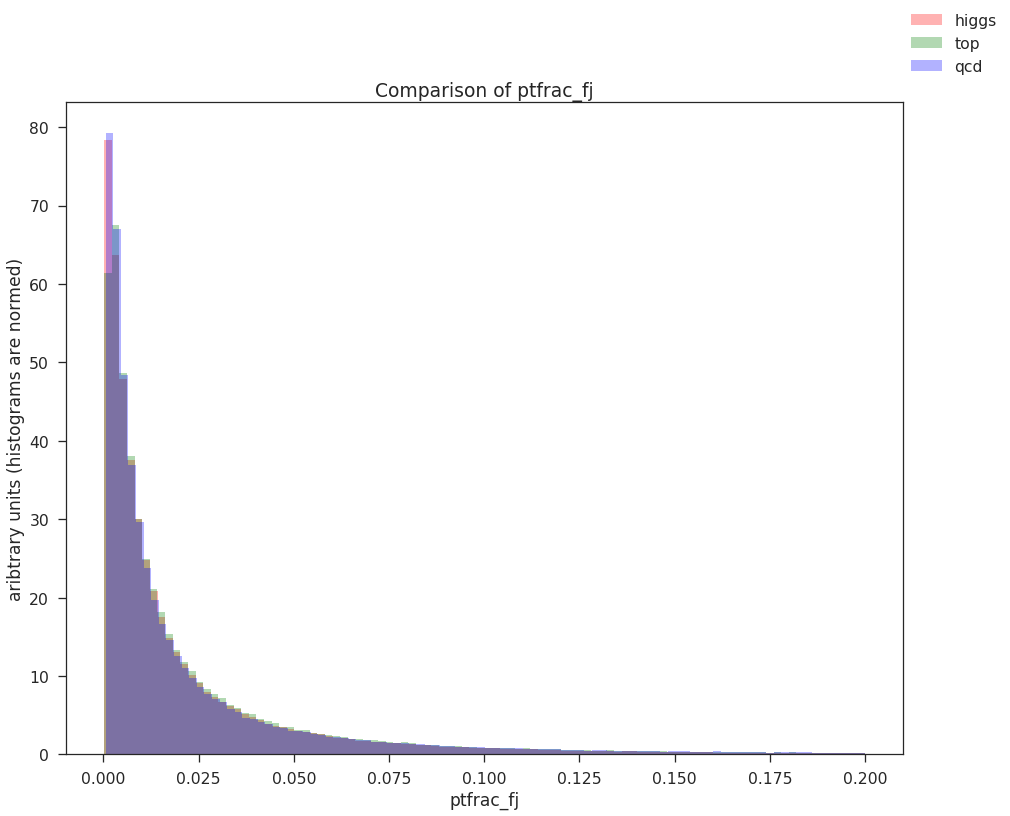

In [209]:
hist_compare('ptfrac_fj')

### Training categories

* Category 0: Higgs fat jets (`GhostHBosonsCount > 0`)
* Category 1: Top fat jets (`GhostTQuarksFinalCount > 0`)
* Category 2: QCD fat jets

Determined like this

```python
if fatjet[fj_attr['GhostHBosonsCount']] > 0:
    category = CAT_HIGGS
elif fatjet[fj_attr['GhostTQuarksFinalCount']] > 0:
    category = CAT_TOP
else:
    category = CAT_QCD
```

The category is stored as attribute `truth_category`.

### Names of all attributes

In [210]:
var_names = [
    'chiSquared',
    'numberDoF',
    'IP3D_signed_d0',
    'IP2D_signed_d0',
    'IP3D_signed_z0',
    'IP3D_signed_d0_significance',
    'IP3D_signed_z0_significance',
    'numberOfInnermostPixelLayerHits',
    'numberOfNextToInnermostPixelLayerHits',
    'numberOfPixelHits',
    'numberOfPixelHoles',
    'numberOfPixelSharedHits',
    'numberOfPixelSplitHits',
    'numberOfSCTHits',
    'numberOfSCTHoles',
    'numberOfSCTSharedHits',
    'pt',
    'eta',
    'deta',
    'dphi',
    'dr',
    'ptfrac',
    'deta_fj',    # added by us
    'dphi_fj',    # added by us
    'dr_fj',      # added by us
    'ptfrac_fj',  # added by us
    'min_deta',   # added by us
    'max_deta',   # added by us
]

### Combine and shuffle data

In [245]:
data = pd.concat([higgs, top, qcd])
print(data['truth_category'].head())
data = data.sample(frac=1)
print(data['truth_category'].head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: truth_category, dtype: float64
5948     1.0
14668    1.0
14166    2.0
15070    0.0
14681    1.0
Name: truth_category, dtype: float64


### Extract labels and delete them from dataframes

In [246]:
labels = data['truth_category']
labels.head()

5948     1.0
14668    1.0
14166    2.0
15070    0.0
14681    1.0
Name: truth_category, dtype: float64

In [247]:
data.drop('truth_category', axis=1, inplace=True)

### Mean normalize

In [248]:
data.head(3)

chiSquared_trk0  numberDoF_trk0  IP3D_signed_d0_trk0  \
5948         35.763100            42.0             0.658699   
14668        79.544022            50.0             0.164447   
14166        37.841301            36.0             1.081000   

       IP2D_signed_d0_trk0  IP3D_signed_z0_trk0  \
5948              0.658699             0.395303   
14668             0.164447             0.128135   
14166            -1.081000             0.350014   

       IP3D_signed_d0_significance_trk0  IP3D_signed_z0_significance_trk0  \
5948                          40.074020                          6.955333   
14668                         12.377812                          3.681044   
14166                         52.683102                          1.756827   

       numberOfInnermostPixelLayerHits_trk0  \
5948                                    1.0   
14668                                   1.0   
14166                                   0.0   

       numberOfNextToInnermostPixelLayerHits_trk0  numberOfPixelHits_trk0  \
5948                                          1.0                     4.0   
14668                                         1.0                     4.0   
14166                                         0.0                     2.0   

            ...        min_deta_trk15  max_deta_trk15  min_deta_trk16  \
5948        ...              0.006753        0.564693        0.002492   
14668       ...                   NaN             NaN             NaN   
14166       ...              0.000759        0.187968        0.002046   

       max_deta_trk16  min_deta_trk17  max_deta_trk17  min_deta_trk18  \
5948         0.472951        0.015626        0.495225        0.003997   
14668             NaN             NaN             NaN             NaN   
14166        0.224438        0.002046        0.226484             NaN   

       max_deta_trk18  min_deta_trk19  max_deta_trk19  
5948         0.553943        0.000442        0.599686  
14668             NaN             NaN             NaN  
14166             NaN             NaN             NaN  

[3 rows x 560 columns]

In [249]:
data = (data - data.mean()) / data.var()
data.head(3)

chiSquared_trk0  numberDoF_trk0  IP3D_signed_d0_trk0  \
5948         -0.016924        0.036155             0.037073   
14668         0.046088        0.080596            -0.395817   
14166        -0.013933        0.002824             0.406943   

       IP2D_signed_d0_trk0  IP3D_signed_z0_trk0  \
5948              0.061026             0.146395   
14668            -0.358805            -0.247873   
14166            -1.416718             0.079561   

       IP3D_signed_d0_significance_trk0  IP3D_signed_z0_significance_trk0  \
5948                           0.014496                          0.036995   
14668                         -0.009427                          0.000042   
14166                          0.025387                         -0.021674   

       numberOfInnermostPixelLayerHits_trk0  \
5948                               1.265445   
14668                              1.265445   
14166                             -1.886480   

       numberOfNextToInnermostPixelLayerHits_trk0  numberOfPixelHits_trk0  \
5948                                     0.841458                0.482044   
14668                                    0.841458                0.482044   
14166                                   -2.584443               -0.711701   

            ...        min_deta_trk15  max_deta_trk15  min_deta_trk16  \
5948        ...            -10.520707        1.478780      -13.664986   
14668       ...                   NaN             NaN             NaN   
14166       ...            -14.990202       -3.854268      -13.991002   

       max_deta_trk16  min_deta_trk17  max_deta_trk17  min_deta_trk18  \
5948         0.110790       -4.295203        0.340972       -12.20432   
14668             NaN             NaN             NaN             NaN   
14166       -3.365159      -14.227124       -3.412260             NaN   

       max_deta_trk18  min_deta_trk19  max_deta_trk19  
5948         1.096005      -14.483185        1.668605  
14668             NaN             NaN             NaN  
14166             NaN             NaN             NaN  

[3 rows x 560 columns]

### More plots after normalising the data

In [241]:
def hist_compare_df(data, labels, variable, xlim=None):
    '''Plot the distribution of max_tracks leading tracks of specified variable'''
    
    higgs = data.loc[labels == 0]
    top = data.loc[labels == 1]
    qcd = data.loc[labels == 2]
    
    colors = ['r', 'g', 'b']
    labels = ['higgs', 'top', 'qcd']

    indices = [variable + '_trk' + str(j) for j in range(max_tracks)]
    ax, fig = plt.subplots()
    for i, input_data in enumerate([higgs, top, qcd]):
        data = input_data.loc[:, indices].values.reshape(-1, 1)
        plt.hist(data[~np.isnan(data)], density=True, bins=100, histtype='stepfilled', color=colors[i], alpha=0.3, label=labels[i], linewidth=4)
    ax.legend()
    if xlim:
        plt.xlim(*xlim)
    plt.title('Comparison of {}'.format(variable))
    plt.xlabel(variable)
    plt.ylabel('aribtrary units (histograms are normed)')
    plt.show()

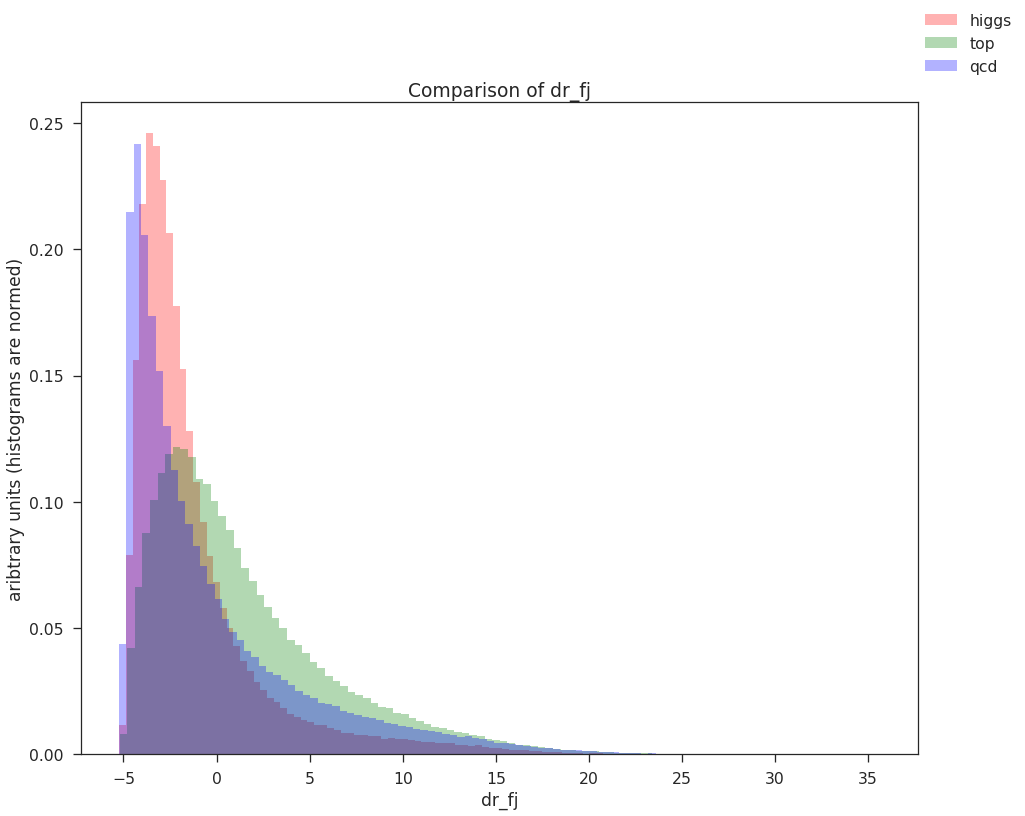

In [250]:
hist_compare_df(data, labels, 'dr_fj')

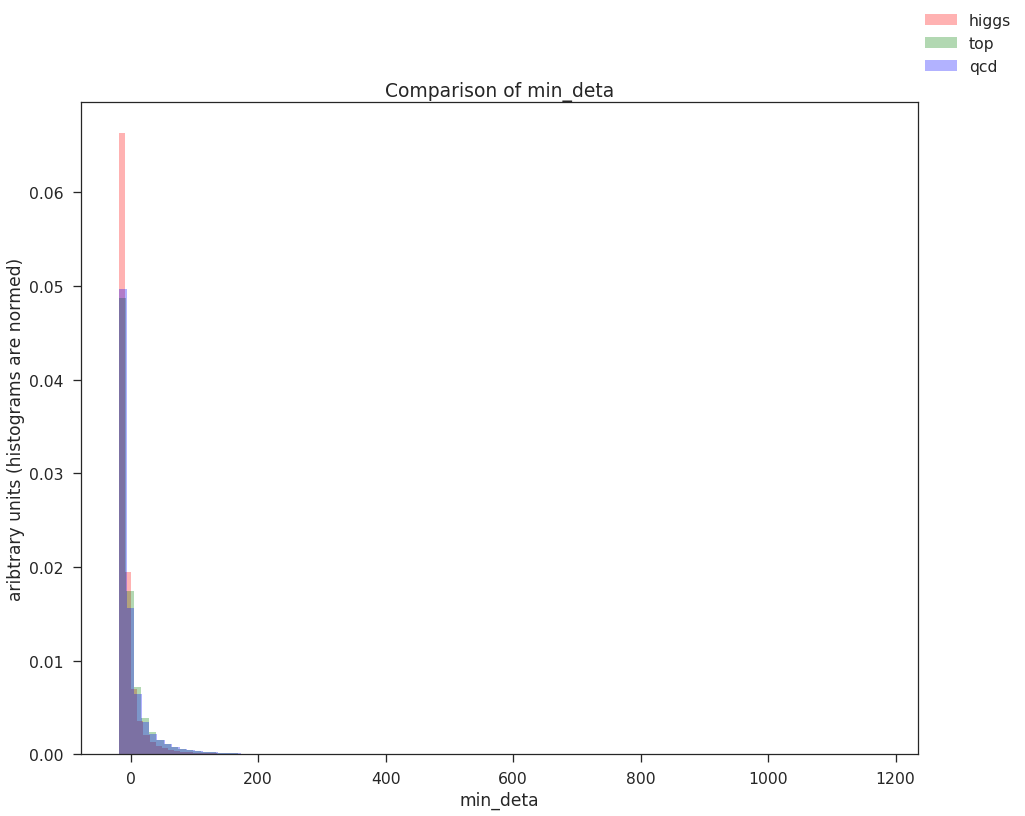

In [251]:
hist_compare_df(data, labels, 'min_deta')

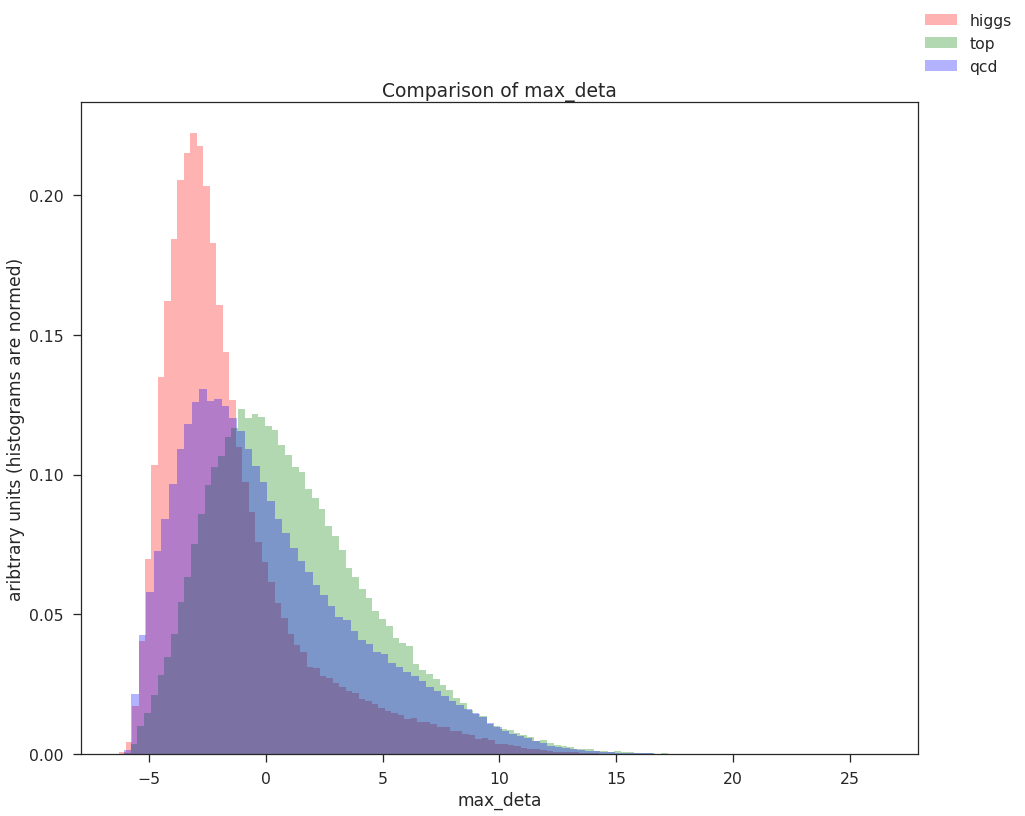

In [252]:
hist_compare_df(data, labels, 'max_deta')

### Split into two sets of inputs and reshape the data

We want to separate the inputs that are usually used to calculate the track category from the rest.

The rest is: $d_0$ and $z_0$ significances, $p_\text{T}^\text{frac, FJ}$, $\Delta R(\text{track}, \text{fat jet})$.

We call the two sets of inputs **category like** and **high level**.

All quantities that go into the calulation of the quality are shown in the table, that is taken from ATL-PHYS-PUB-2015-022.

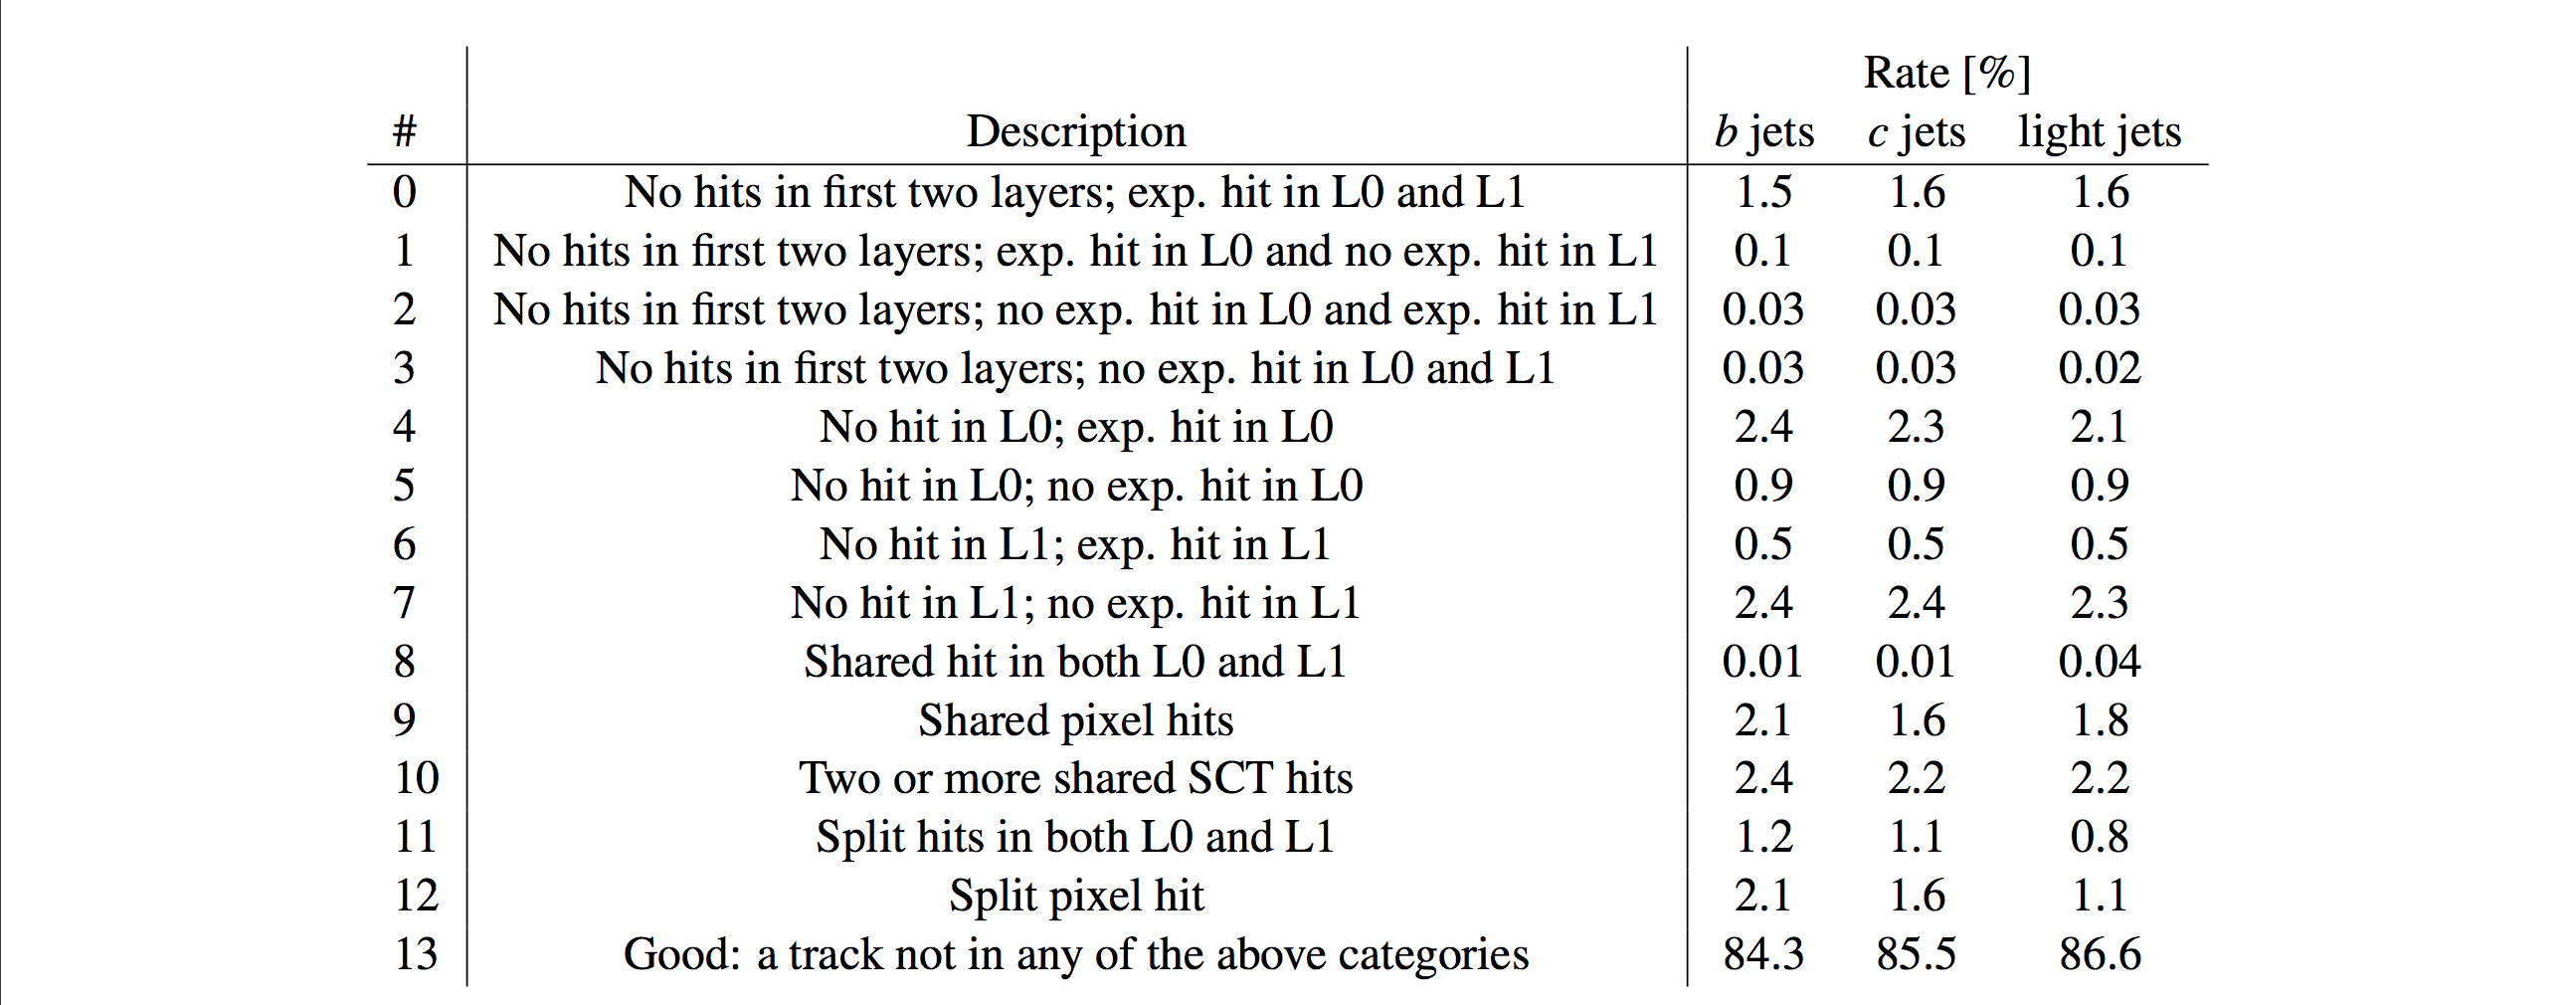


The desired **input shape** is (ntracks, nattrs), where ntracks is (up to) `max_tracks` and nattrs is 9 for category like attributes and 4 for the high level attributes.

The number of tracks are the _timesteps_ in the usual RNN jargon, i.e. `max_tracks`.

Before filling the numpy array, we also replace all `NaN`s with -999 for the masking layer.

In [253]:
data.fillna(-999, inplace=True)

In [254]:
vars_categorylike = [
    'numberOfInnermostPixelLayerHits',
    'numberOfNextToInnermostPixelLayerHits',
    'numberOfPixelHits',
    'numberOfPixelHoles',
    'numberOfPixelSharedHits',
    'numberOfPixelSplitHits',
    'numberOfSCTHits',
    'numberOfSCTHoles',
    'numberOfSCTSharedHits'
]
vars_highlevel = [
    'IP3D_signed_d0',
    'IP3D_signed_z0',
    'IP3D_signed_d0_significance',
    'IP3D_signed_z0_significance',
    'dr_fj',      # added by us
    'ptfrac_fj',  # added by us
    'min_deta',   # added by us
    'max_deta'    # added by us    
]

Initialize empty arrays

In [255]:
data_tensor_categorylike = np.empty((len(data), max_tracks, len(vars_categorylike)))
data_tensor_highlevel = np.empty((len(data), max_tracks, len(vars_highlevel)))

Fill them

In [256]:
for j in range(max_tracks):
    indices_categorylike = [varName + '_trk' + str(j) for varName in vars_categorylike]
    data_tensor_categorylike[:,j] = data.loc[:, indices_categorylike].values
    indices_highlevel = [varName + '_trk' + str(j) for varName in vars_highlevel]
    data_tensor_highlevel[:, j] = data.loc[:, indices_highlevel].values

In [257]:
print(data_tensor_categorylike.shape)
print(data_tensor_highlevel.shape)

(60000, 20, 9)
(60000, 20, 8)


### OHE target

In [258]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(labels.values.reshape(-1, 1))
Y = enc.transform(labels.values.reshape(-1, 1)).toarray()

In [259]:
labels.head()

5948     1.0
14668    1.0
14166    2.0
15070    0.0
14681    1.0
Name: truth_category, dtype: float64

In [260]:
Y[0:5]

array([[ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.]])

### Custom callback to show progress

See: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

In [273]:
import time
class PlotLearning(Callback):
    def __init__(self, n_epochs):
        self.epochs = n_epochs
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses_autoenc = []
        self.val_losses_autoenc = []
        self.acc_autoenc = []
        self.val_acc_autoenc = []
        self.losses_highlevel = []
        self.val_losses_highlevel = []
        self.acc_highlevel = []
        self.val_acc_highlevel = []        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):        
        self.logs.append(logs)
        self.x.append(self.i)
        # losses
        self.losses_highlevel.append(logs.get('categorical_output_loss'))
        self.losses_autoenc.append(logs.get('autoenc_output_loss'))
        # validation losses
        self.val_losses_highlevel.append(logs.get('val_categorical_output_loss'))
        self.val_losses_autoenc.append(logs.get('val_autoenc_output_loss'))
        # accuracy
        self.acc_highlevel.append(logs.get('categorical_output_acc'))
        self.acc_autoenc.append(logs.get('autoenc_output_acc'))
        # validation accuracy
        self.val_acc_highlevel.append(logs.get('val_categorical_output_acc'))
        self.val_acc_autoenc.append(logs.get('val_autoenc_output_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        
        time.sleep(0.5)
        clear_output(wait=True)
        
        # ax1.set_yscale('log')
        ax1.set_xlim(-1, self.epochs + 1)
        ax1.plot(self.x, self.losses_highlevel, label="loss - fat jet label", c='r',  marker='o')
        ax1.plot(self.x, self.val_losses_highlevel, label="val_loss - fat jet label", c='r', ls=':',  marker='o')
        ax1.plot(self.x, self.losses_autoenc, label='loss - autoencoder', c='b',  marker='o')
        ax1.plot(self.x, self.val_losses_autoenc, label='val_loss - autoencoder', c='b', ls=':',  marker='o')
        ax1.legend()
        
        ax2.plot(self.x, self.acc_highlevel, label="acc - fat jet label", c='r',  marker='o')
        ax2.plot(self.x, self.val_acc_highlevel, label="val_acc - fat jet label", c='r', ls=':',  marker='o')
        ax2.plot(self.x, self.acc_autoenc, label='acc - autoencoder', c='b',  marker='o')
        ax2.plot(self.x, self.val_acc_autoenc, label='val_acc - autoencoder', c='b', ls=':',  marker='o')
        ax2.legend()
        
        plt.show()

### Build and train model

In [323]:
# input layer for our 26 features
input_categorylike = Input(data_tensor_categorylike.shape[1:], name='input_categorylike')
input_highlevel = Input(data_tensor_highlevel.shape[1:], name='input_highlevel')
# masking layer that will mask (= deactivate) all entries that are -999
masking_categorylike = Masking(mask_value=-999)(input_categorylike)
masking_highlevel = Masking(mask_value=-999)(input_highlevel)
# auto-encoder for the category-like data
# encoding layer
enc1 = Dense(5, activation='relu', initializer='glorot_uniform')(masking_categorylike)
# bottleneck
bn = Dense(2, activation='relu', initializer='glorot_uniform')(enc1)
# decoding layer
dec1 = Dense(5, activation='relu', initializer='glorot_uniform')(bn)
# autoencoder output
autoenc = Dense(data_tensor_categorylike.shape[2],
                activation='tanh', name='autoenc_output')(dec1)
x = concatenate([bn, masking_highlevel])
# LSTM layer
x = LSTM(25, return_sequences=False, initializer='glorot_uniform')(x)
# Dropout layer
x = Dropout(0.2)(x)
y = Dense(3, activation='softmax', name='categorical_output')(x)

In [302]:
split_index=int(0.8 * len(data))
# split_index=10000

train_X_categorylike = data_tensor_categorylike[:split_index, :, :]
test_X_categorylike = data_tensor_categorylike[split_index:, : , :]
train_X_highlevel = data_tensor_highlevel[:split_index, :, :]
test_X_highlevel = data_tensor_highlevel[split_index, :, :]

train_y_highlevel = Y[:split_index, :]
test_y_highlevel = Y[split_index:, :]

In [303]:
print(train_X_categorylike.shape)
print(test_X_categorylike.shape)

(48000, 20, 9)
(12000, 20, 9)


In [325]:
model = Model(inputs=[input_categorylike, input_highlevel], outputs=[autoenc, y])

from keras.optimizers import adam
from keras.optimizers import adadelta
# opt = adam(lr=0.5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
opt = adam()
# opt = adadelta()
model.compile(opt, loss={'categorical_output': 'categorical_crossentropy',
                         'autoenc_output': 'mean_squared_logarithmic_error'},
              metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_categorylike (InputLayer) (None, 20, 9)        0                                            
__________________________________________________________________________________________________
masking_17 (Masking)            (None, 20, 9)        0           input_categorylike[0][0]         
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 20, 6)        60          masking_17[0][0]                 
__________________________________________________________________________________________________
input_highlevel (InputLayer)    (None, 20, 8)        0                                            
__________________________________________________________________________________________________
dense_23 (

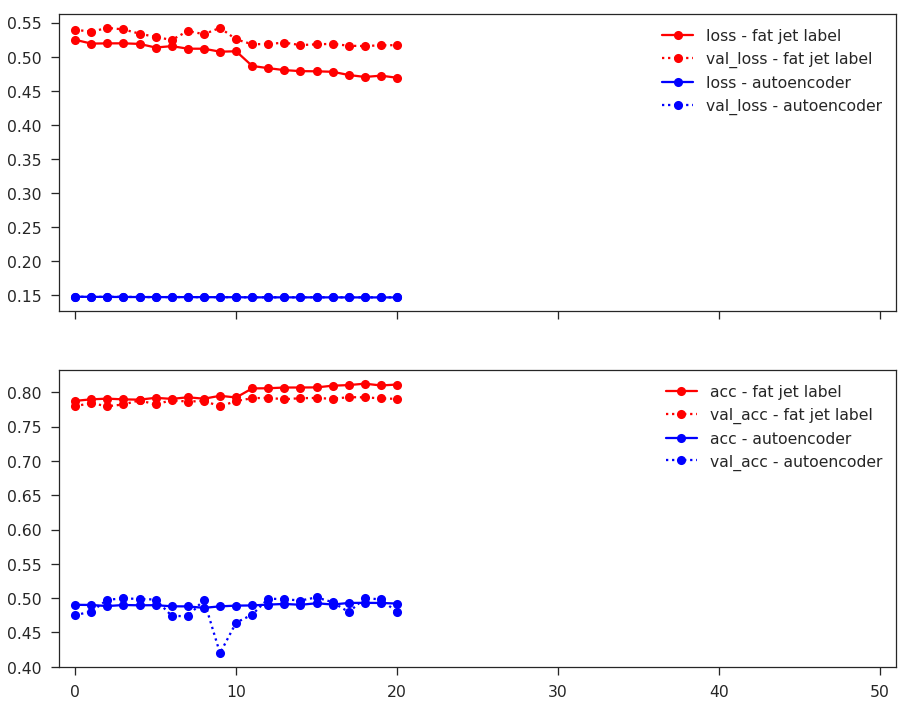

Epoch 00021: early stopping


In [327]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_output_loss',
                                                min_delta=0.01,
                                                patience=5,
                                                verbose=1,
                                                factor=0.25,
                                                min_lr=0.00001)
model.fit([train_X_categorylike, train_X_highlevel], [train_X_categorylike, train_y_highlevel], batch_size=32,
          callbacks = [
            EarlyStopping(verbose=True, patience=9, monitor='val_loss', min_delta=0.005),
            ModelCheckpoint('test.out', 
                            monitor='val_categorical_output_loss',
                            verbose=True,
                            save_best_only=True),
            PlotLearning(n_epochs=50),
            learning_rate_reduction
          ],
          epochs=50, 
          validation_split = 0.2)